### Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
keras = tf.keras

2024-03-03 17:47:28.599881: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-03 17:47:32.690386: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-03 17:47:32.720551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 17:47:46.489548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Series")
    if label:
        plt.legend(fontsize = 14)
    plt.grid()
    
def trend(time, slope = 0):
    return time * slope

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                   np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

### Trend and seasonality

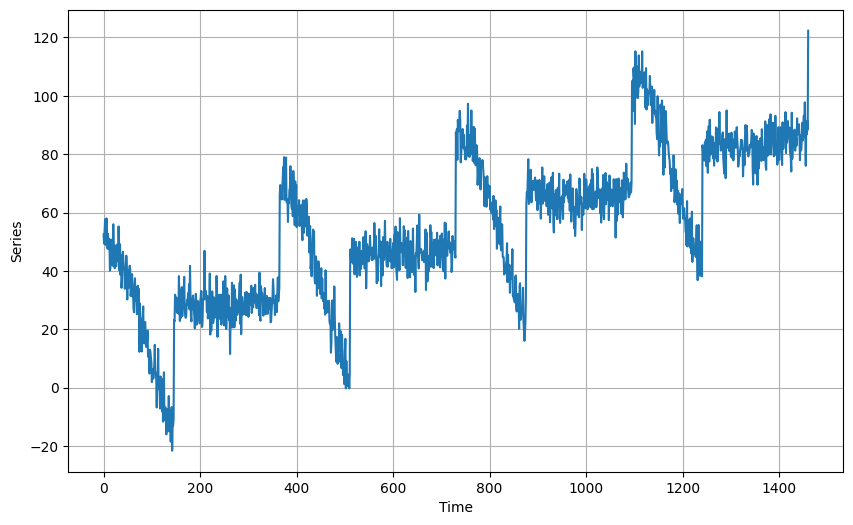

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

### Forecasting with machine learning

In [4]:
def window_dataset(series, window_size, batch_size = 32,
                  shuffle_buffer = 1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

x =  [[68.38925803 68.83505314 64.49016329 68.47447787 70.82682425 75.56566694
  73.06765222 78.98681891 64.32206646 72.44662742 68.91631323 78.85159596
  63.75251065 63.47530333 64.54539987 56.77992891 64.61632792 63.28384682
  67.65466163 68.42349785 75.89651065 71.05770114 63.20005325 61.36063214
  68.06966322 58.75557783 74.25011869 70.71560399 62.18769731 55.67276799]]
y =  [70.70246271]


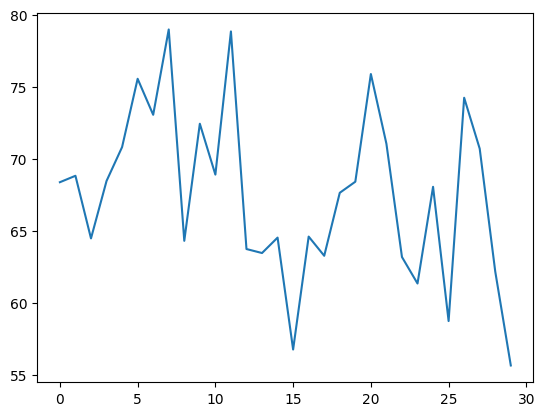

In [5]:
for x, y in window_dataset(series, window_size = 30, batch_size = 1):
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    plt.plot(x.numpy().flatten())
    break

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear model

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
    keras.layers.Dense(1, input_shape = [window_size])
])

optimizer = keras.optimizers.SGD(learning_rate = 1e-4, momentum = 0.9)
model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

model.fit(train_set, epochs = 100, validation_data = valid_set)

Epoch 1/100
31/31 [==============================] - 2s 25ms/step - loss: 27.3537 - mae: 27.8487 - val_loss: 13.2595 - val_mae: 13.7571
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 8.6496 - mae: 9.1347 - val_loss: 7.1471 - val_mae: 7.6357
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 7.0712 - mae: 7.5595 - val_loss: 6.4926 - val_mae: 6.9768
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 6.4617 - mae: 6.9466 - val_loss: 16.4925 - val_mae: 16.9916
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 6.5108 - mae: 6.9960 - val_loss: 10.4577 - val_mae: 10.9521
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 6.5349 - mae: 7.0218 - val_loss: 5.5587 - val_mae: 6.0420
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 5.7831 - mae: 6.2653 - val_loss: 5.3376 - val_mae: 5.8208
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 5

Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 4.4534 - mae: 4.9327 - val_loss: 4.9831 - val_mae: 5.4636
Epoch 64/100
31/31 [==============================] - 0s 4ms/step - loss: 5.0722 - mae: 5.5555 - val_loss: 6.5064 - val_mae: 6.9974
Epoch 65/100
31/31 [==============================] - 0s 4ms/step - loss: 6.3974 - mae: 6.8800 - val_loss: 17.3866 - val_mae: 17.8863
Epoch 66/100
31/31 [==============================] - 0s 4ms/step - loss: 6.0858 - mae: 6.5686 - val_loss: 5.7490 - val_mae: 6.2376
Epoch 67/100
31/31 [==============================] - 0s 6ms/step - loss: 4.5955 - mae: 5.0743 - val_loss: 4.4389 - val_mae: 4.9101
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 4.6817 - mae: 5.1607 - val_loss: 4.5672 - val_mae: 5.0435
Epoch 69/100
31/31 [==============================] - 0s 4ms/step - loss: 4.7497 - mae: 5.2283 - val_loss: 5.9907 - val_mae: 6.4786
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 

#### Find the best learning rate

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
# valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape = [window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10 ** (epoch / 30))

optimizer = keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9)

model.compile(loss = keras.losses.Huber(),
             metrics = ['mae'],
             optimizer = optimizer)

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 66.9122 - mae: 67.4116 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 51.7912 - mae: 52.2893 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 34.7337 - mae: 35.2311 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 20.1744 - mae: 20.6701 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 14.8409 - mae: 15.3304 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 14.6048 - mae: 15.0955 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 14.4533 - mae: 14.9420 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 14.3067 - mae: 14.7959 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 14.1402 - mae: 14.6285 

#### Plot losses as learning rate changes in every 30 epochs

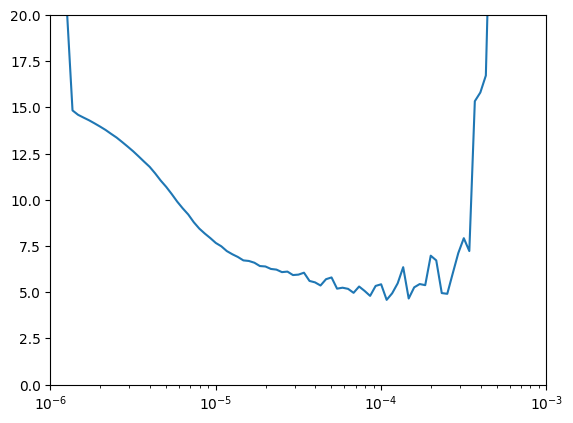

In [9]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-6, 1e-3,0, 20])
plt.show()

#### Early stopping

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape = [window_size])
])

optimizer = keras.optimizers.SGD(learning_rate = 1e-5, momentum = .9)

model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience = 10)

history = model.fit(train_set, epochs = 500,
                    validation_data = valid_set,
                    callbacks = [early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 9ms/step - loss: 83.6325 - mae: 84.1318 - val_loss: 20.6109 - val_mae: 21.1068
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 13.1004 - mae: 13.5907 - val_loss: 12.8706 - val_mae: 13.3636
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 9.5296 - mae: 10.0181 - val_loss: 8.8084 - val_mae: 9.2993
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 8.8603 - mae: 9.3466 - val_loss: 8.0255 - val_mae: 8.5103
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 8.1656 - mae: 8.6467 - val_loss: 7.5703 - val_mae: 8.0523
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 7.5964 - mae: 8.0793 - val_loss: 7.3002 - val_mae: 7.7784
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 7.1953 - mae: 7.6796 - val_loss: 6.9841 - val_mae: 7.4618
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 6

31/31 [==============================] - 0s 5ms/step - loss: 5.0030 - mae: 5.4795 - val_loss: 5.0599 - val_mae: 5.5395
Epoch 64/500
31/31 [==============================] - 0s 4ms/step - loss: 5.0018 - mae: 5.4814 - val_loss: 5.0315 - val_mae: 5.5067
Epoch 65/500
31/31 [==============================] - 0s 4ms/step - loss: 4.9856 - mae: 5.4621 - val_loss: 5.0301 - val_mae: 5.5037
Epoch 66/500
31/31 [==============================] - 0s 4ms/step - loss: 4.9857 - mae: 5.4633 - val_loss: 5.1976 - val_mae: 5.6755
Epoch 67/500
31/31 [==============================] - 0s 4ms/step - loss: 5.0920 - mae: 5.5738 - val_loss: 5.1632 - val_mae: 5.6444
Epoch 68/500
31/31 [==============================] - 0s 4ms/step - loss: 5.1513 - mae: 5.6324 - val_loss: 4.9908 - val_mae: 5.4687
Epoch 69/500
31/31 [==============================] - 0s 4ms/step - loss: 4.9795 - mae: 5.4593 - val_loss: 4.9905 - val_mae: 5.4681
Epoch 70/500
31/31 [==============================] - 0s 5ms/step - loss: 4.9328 - mae: 5

Epoch 125/500
31/31 [==============================] - 0s 4ms/step - loss: 4.5361 - mae: 5.0070 - val_loss: 4.5864 - val_mae: 5.0586
Epoch 126/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5133 - mae: 4.9889 - val_loss: 4.5781 - val_mae: 5.0519
Epoch 127/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5139 - mae: 4.9889 - val_loss: 4.8873 - val_mae: 5.3637
Epoch 128/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5171 - mae: 4.9955 - val_loss: 4.6008 - val_mae: 5.0731
Epoch 129/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5015 - mae: 4.9734 - val_loss: 4.6241 - val_mae: 5.1048
Epoch 130/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5058 - mae: 4.9798 - val_loss: 4.5768 - val_mae: 5.0533
Epoch 131/500
31/31 [==============================] - 0s 5ms/step - loss: 4.6186 - mae: 5.0957 - val_loss: 4.7832 - val_mae: 5.2640
Epoch 132/500
31/31 [==============================] - 0s 4ms/step - 

#### Make some forecasts

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [24]:
lin_forecast = model_forecast(model, series[split_time - window_size: -1], window_size).

15/15 [==============================] - 0s 6ms/step


In [25]:
lin_forecast

array([ 63.52916 ,  66.23417 ,  70.31654 ,  71.018036,  64.23013 ,
        66.330376,  67.67444 ,  68.0576  ,  68.82857 ,  67.69537 ,
        65.82668 ,  69.18319 ,  67.917755,  70.363205,  67.49066 ,
        70.88334 ,  66.59746 ,  68.29065 ,  63.825603,  65.71129 ,
        62.738895,  65.950005,  65.94403 ,  66.8209  ,  67.318214,
        68.83537 ,  71.54248 ,  69.76752 ,  67.33861 ,  67.46854 ,
        67.64564 ,  64.84816 ,  60.520702,  63.50128 ,  64.63693 ,
        66.00175 ,  65.68698 ,  65.55099 ,  63.395878,  64.44193 ,
        64.0921  ,  69.233116,  69.66431 ,  67.58169 ,  65.299164,
        69.03763 ,  68.5818  ,  68.517815,  64.59591 ,  66.98566 ,
        69.3754  ,  70.96001 ,  67.09353 ,  64.15161 ,  66.90835 ,
        68.65465 ,  64.98219 ,  64.630646,  66.368675,  67.98804 ,
        67.16339 ,  68.46028 ,  64.92245 ,  63.096603,  63.34891 ,
        64.29378 ,  60.12255 ,  65.33174 ,  61.844414,  65.42178 ,
        64.994576,  65.97624 ,  67.696915,  66.85721 ,  66.515

In [11]:
lin_forecast.shape

(461,)

In [12]:
len(series)

1461

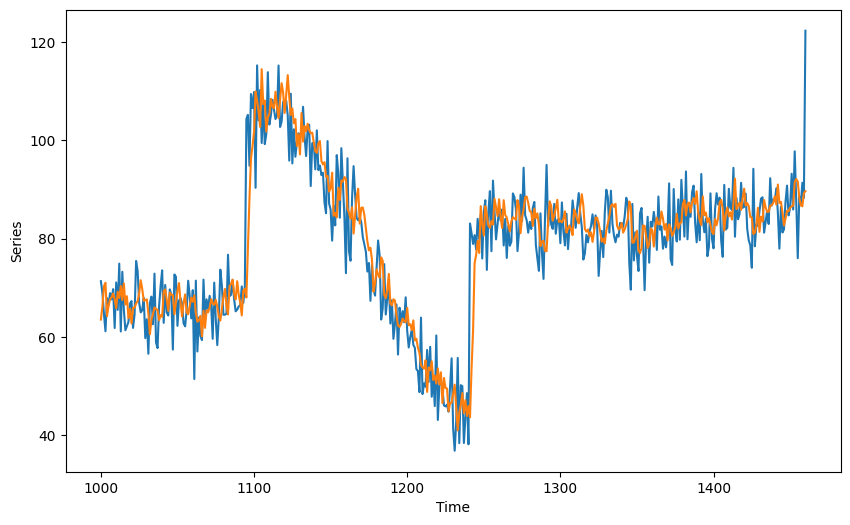

In [13]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [14]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.0064535

### Dense model forecasting


#### Find the best learning rate

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
# valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation = 'relu', input_shape = [window_size]),
    keras.layers.Dense(10, activation = 'relu'),
    keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epochs : 1e-7 * 10 ** (epochs / 20))

model.compile(loss = keras.losses.Huber(),
             optimizer = keras.optimizers.SGD(learning_rate = 1e-7, momentum = .9),
             metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 49.6068 - mae: 50.1067 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 49.0786 - mae: 49.5785 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 48.4422 - mae: 48.9420 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 47.7450 - mae: 48.2447 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 46.9827 - mae: 47.4822 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 46.1477 - mae: 46.6471 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 45.2505 - mae: 45.7500 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 44.2969 - mae: 44.7965 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 43.3121 - mae: 43.8115 

##### Plot change in loss with regard to change in learning_rate

(1e-07, 0.005, 0.0, 30.0)

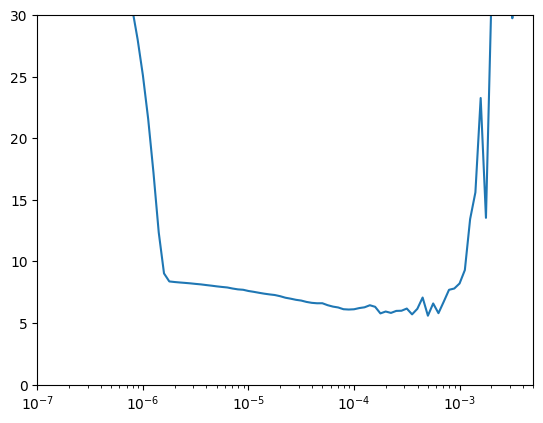

In [28]:
plt.semilogx(history.history['lr'], history.history['mae']);
plt.axis([1e-7, 5e-3, 0, 30])

### Use a dense layer to make predictions

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation = 'relu', input_shape = [window_size]),
    keras.layers.Dense(10, activation = 'relu'),
    keras.layers.Dense(1)
])

model.compile(loss = keras.losses.Huber(),
             optimizer = keras.optimizers.SGD(learning_rate = 1e-5, momentum = 0.9),
             metrics = ['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience = 10)

history = model.fit(train_set, epochs = 500,
                   validation_data = valid_set,
                   callbacks = [early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 8ms/step - loss: 13.1476 - mae: 13.6385 - val_loss: 9.7798 - val_mae: 10.2691
Epoch 2/500
31/31 [==============================] - 0s 4ms/step - loss: 9.0311 - mae: 9.5192 - val_loss: 8.1725 - val_mae: 8.6611
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 8.5208 - mae: 9.0057 - val_loss: 7.4832 - val_mae: 7.9661
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 8.3325 - mae: 8.8182 - val_loss: 7.3555 - val_mae: 7.8383
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 8.1240 - mae: 8.6091 - val_loss: 7.2669 - val_mae: 7.7558
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 7.9388 - mae: 8.4213 - val_loss: 7.2272 - val_mae: 7.7084
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 7.7567 - mae: 8.2415 - val_loss: 6.8467 - val_mae: 7.3203
Epoch 8/500
31/31 [==============================] - 0s 4ms/step - loss: 7.5753 

Epoch 125/500
31/31 [==============================] - 0s 4ms/step - loss: 4.9023 - mae: 5.3802 - val_loss: 4.8243 - val_mae: 5.3020
Epoch 126/500
31/31 [==============================] - 0s 4ms/step - loss: 4.8622 - mae: 5.3398 - val_loss: 4.8221 - val_mae: 5.3001
Epoch 127/500
31/31 [==============================] - 0s 4ms/step - loss: 4.8596 - mae: 5.3355 - val_loss: 4.8079 - val_mae: 5.2874
Epoch 128/500
31/31 [==============================] - 0s 4ms/step - loss: 4.8431 - mae: 5.3206 - val_loss: 4.8310 - val_mae: 5.3074
Epoch 129/500
31/31 [==============================] - 0s 4ms/step - loss: 4.8860 - mae: 5.3634 - val_loss: 4.7961 - val_mae: 5.2767
Epoch 130/500
31/31 [==============================] - 0s 4ms/step - loss: 4.8630 - mae: 5.3430 - val_loss: 4.8254 - val_mae: 5.3018
Epoch 131/500
31/31 [==============================] - 0s 4ms/step - loss: 4.8714 - mae: 5.3475 - val_loss: 4.7835 - val_mae: 5.2653
Epoch 132/500
31/31 [==============================] - 0s 4ms/step - 

Epoch 248/500
31/31 [==============================] - 0s 4ms/step - loss: 4.6078 - mae: 5.0860 - val_loss: 4.6037 - val_mae: 5.0848
Epoch 249/500
31/31 [==============================] - 0s 4ms/step - loss: 4.5931 - mae: 5.0676 - val_loss: 4.6293 - val_mae: 5.1088
Epoch 250/500
31/31 [==============================] - 0s 4ms/step - loss: 4.5821 - mae: 5.0564 - val_loss: 4.6338 - val_mae: 5.1127
Epoch 251/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5833 - mae: 5.0577 - val_loss: 4.7248 - val_mae: 5.2019
Epoch 252/500
31/31 [==============================] - 0s 4ms/step - loss: 4.6221 - mae: 5.0989 - val_loss: 4.6950 - val_mae: 5.1708
Epoch 253/500
31/31 [==============================] - 0s 4ms/step - loss: 4.5631 - mae: 5.0368 - val_loss: 4.6293 - val_mae: 5.1083
Epoch 254/500
31/31 [==============================] - 0s 4ms/step - loss: 4.5654 - mae: 5.0368 - val_loss: 4.6161 - val_mae: 5.0960
Epoch 255/500
31/31 [==============================] - 0s 4ms/step - 

In [30]:
dense_forecast = model_forecast(model,
                               series[split_time - window_size: -1],
                               window_size)[:, 0]

15/15 [==============================] - 0s 6ms/step


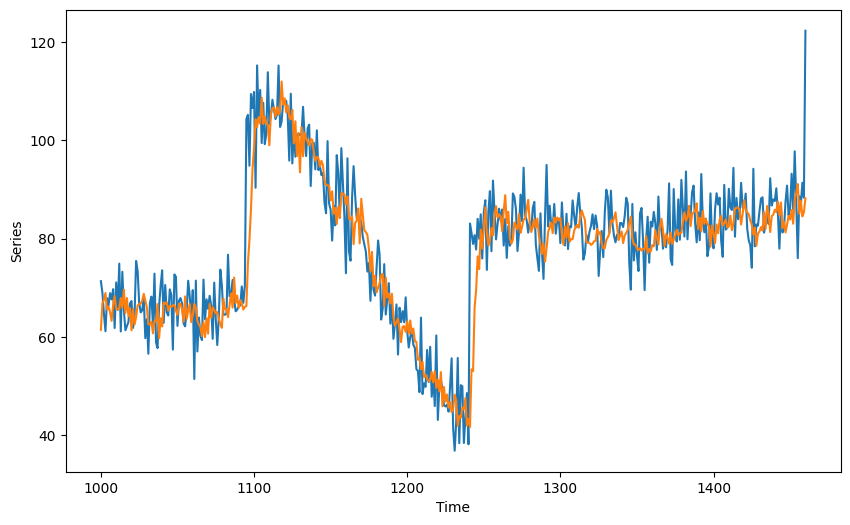

In [31]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [32]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.0349593

The dense model outperformed the linear regression just by a lil bit.